# Imports

In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool, Lock

# Load data

In [2]:
data_dir = 'ml-1m'

movies_filename = 'movies.dat'
users_filename = 'users.dat'
ratings_filename = 'ratings.dat'

movie_columns = ['MovieID', 'Title', 'Genres']
user_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
rating_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']


def make_dataframe(data_dir, filename, columns):
    """
    Creates a dataframe from a data file
    
    data_dir: string, directory of data files
    filename: string, data filename
    columns: list, names for the columns of the dataframe
    
    """
    data_file = os.path.join(data_dir, filename)
    return pd.read_csv(data_file, delimiter='::', names=columns, encoding='latin-1', engine='python')


# Make the data frames for each data file
movies = make_dataframe(data_dir, movies_filename, movie_columns)
users = make_dataframe(data_dir, users_filename, user_columns)
ratings = make_dataframe(data_dir, ratings_filename, rating_columns)
data = (users, movies, ratings)

# Utility functions

In [3]:
def rmse(errors):
    """
    Calculates the root mean squared error for an array of errors
    
    errors: array, array containing errors
    """
    return np.sqrt(np.mean(np.square(errors)))


def mae(errors):
    """
    Calculates the mean absolute error for an array of errors
    
    errors: array, array containing errors
    """
    return np.mean(np.abs(errors))


def crop_ratings(arr):
    """
    Ratings can only have values between 1.0 and 5.0. 
    This function sets all ratings > 5 to 5 and < 1 to 1.
    
    arr: array, array containing ratings
    """
    new_arr = np.where(arr > 5.0, 5.0, arr)
    new_arr = np.where(new_arr < 1.0, 1.0, new_arr)
    return new_arr


def rating_errors(data_set, model):
    """
    Calculates the rmse and mae of the errors between ratings from and data set
    and ratings predicted by a model.
    
    test_set: Dataframe, dataframe with the test data
    model: function, function that can act on the rows of a dataframe
    """
    errors = data_set['Rating'] - data_set.apply(model, axis=1)
    return rmse(errors), mae(errors)


def ids_to_indices(movie_ids):
    """
    We want for each movie ID the corresponding index of an array. For the users this 
    is straightforward, since the the user ID's are integers from 1 to the number of 
    users and we can just subtract 1 to get all the indices. For some reason, some integers 
    are skipped in the movie ID's, so we cannot use them directly as indices of an array. 
    
    For example: there is no movie with ID '91', so we want the movie with ID '92' 
    to correspond to an index of 90 (note that the first movie ID is '1' which 
    corresponds to index 0)
    
    Therefore we make an indices array with holes, which has parts like 
    [0, 1, ..., 218, 0, 219, 220, 221, ...]. The IDs '91' and '221' are missing. So a movie 
    with ID '222' will then take the 221st element of this array, which will take the value
    219 for the index, because 2 zeros are inserted for the missing IDs.
    
    movie_ids: array, array containing the ID's of all movies
    """
    ids_to_indices_arr = np.array([], dtype=np.int32)
    skipped_integers = 0
    for i in np.arange(len(movie_ids)):
        if movie_ids[i] == i + 1 + skipped_integers:
            ids_to_indices_arr = np.append(ids_to_indices_arr, i)
        else:
            while movie_ids[i] != i + 1 + skipped_integers:
                ids_to_indices_arr = np.append(ids_to_indices_arr, 0)
                skipped_integers += 1
            ids_to_indices_arr = np.append(ids_to_indices_arr, i)
    return ids_to_indices_arr


def make_movie_indices(data_set, movie_ids):
    """
    For a certain data set with movie ID's, return the corresponding indices of an array.
    
    data_set: Dataframe, dataframe containing ratings
    movie_ids: array, array containing the ID's of all movies
    """
    data_set_movie_ids = data_set['MovieID'].values - 1
    ids_to_indices_arr = ids_to_indices(movie_ids)
    movie_indices = ids_to_indices_arr[data_set_movie_ids]
    return movie_indices

# Naive models 1, 2 and 3

## Functions

In [4]:
def build_naive_model(mean_rating, train_set, model_type, model_specific_params):
    """
    Builds the naive model of a given type.
    
    mean_ratings: float, the mean of all ratings (in the train set)
    train_set: Dataframe, dataframe containing the training data
    model_type: string, type of the model (use '1', '2' or '3')
    model_specific_parmas: dict, dictionary containing objects specific to the model type
    """
    if model_type == '1':
        def model(row):
            return mean_rating
        return model
    elif model_type == '2':
        mean_rating_per_user = np.array([])
        
        # Calculate the mean rating for every user in the training set
        for user_id in model_specific_params['user_ids']:
            user_subset = train_set[train_set['UserID'].values == user_id]
            mean_rating_per_user = np.append(mean_rating_per_user, np.mean(user_subset['Rating']))
        
        # Replace the user mean rating by the global mean rating if it is not available
        mean_rating_per_user = np.where(np.isnan(mean_rating_per_user), mean_rating, mean_rating_per_user)

        def model(row):
            user_id = row['UserID'] - 1
            return mean_rating_per_user[user_id]
        return model
    elif model_type == '3':
        mean_rating_per_movie = np.array([])
        
        # Calculate the mean rating for every movie in the training set
        for movie_id in model_specific_params['movie_ids']:
            movie_subset = train_set[train_set['MovieID'].values == movie_id]
            mean_rating_per_movie = np.append(mean_rating_per_movie, np.mean(movie_subset['Rating']))
        
        # Replace the movie mean rating by the global mean rating if it is not available
        mean_rating_per_movie = np.where(np.isnan(mean_rating_per_movie), mean_rating, mean_rating_per_movie)

        def model(row):
            movie_id = row['MovieID'] - 1
            return mean_rating_per_movie[model_specific_params['ids_to_indices_arr'][movie_id]]
        return model
    else:
        return ValueError(f'Model type {model_type} is unknown.')

    
def naive_model_fold_error(ratings, train_indices, test_indices, model_type, model_specific_params):
    """
    For a given fold, build the naive model and calculate its error on the test set.
    
    ratings: Dataframe, dataframe containing all ratings
    train_indices: array, indices of the training set
    test_indices array, indices of the test set
    model_type: string, type of the model (use '1', '2' or '3')
    model_specific_parmas: dict, dictionary containing objects specific to the model type
    """
    train_set = ratings.iloc[train_indices]
    test_set = ratings.iloc[test_indices]

    mean_rating = train_set['Rating'].mean()

    model = build_naive_model(mean_rating, train_set, model_type, model_specific_params)
    
    train_rmse, train_mae = rating_errors(train_set, model)
    test_rmse, test_mae = rating_errors(test_set, model)
    
    return train_rmse, test_rmse, train_mae, test_mae


def test_naive_model(data, model_type, n_folds=5):
    """
    Calculates the error for a given model. Bias in training and test set selection is reduced
    by using cross-validation. To speed up the process, we use multiprocessing to divide the 
    folds over different cores.
    
    data: tuple, contains the user, movie and rating dataframe
    model_type: string, type of the model (use '1', '2' or '3')
    n_folds: int, the number of folds to use for cross-validation
    """
    users, movies, ratings = data
    
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    print(f'Testing naive model {model_type}...')
    
    if model_type == '1':
        model_specific_params = {}
    elif model_type == '2':
        model_specific_params = {'user_ids': users['UserID']}
    elif model_type == '3':
        model_specific_params = {'movie_ids': movies['MovieID']}
        model_specific_params.update({'ids_to_indices_arr': 
                                      ids_to_indices(model_specific_params['movie_ids'])})
    else:
        return ValueError(f'Model type {model_type} is unknown.')
    
    # Simulatneously calculate the errors for each fold
    params = [(ratings,
               train_indices, 
               test_indices, 
               model_type,
               model_specific_params) for train_indices, test_indices in cv.split(ratings)]
    pool = Pool(n_folds)
    fold_errors = pool.starmap(naive_model_fold_error, params)
    pool.close()
    pool.join()
    
    # fold_errors has dimensions [n_folds, n_error_types]
    print('\nResults:')
    print('mean train rmse', np.mean(fold_errors, axis=0)[0])
    print('mean test rmse', np.mean(fold_errors, axis=0)[1])
    print('mean train mae', np.mean(fold_errors, axis=0)[2])
    print('mean test mae', np.mean(fold_errors, axis=0)[3])

## Testing naive model 1

In [5]:
t0 = time.time()

test_naive_model(data, model_type='1')

run_time = time.time() - t0
print('Run time:', run_time, ' sec')

Testing naive model 1...

Results:
mean train rmse 1.1171010587983956
mean test rmse 1.1171014505284547
mean train mae 0.9338605988479152
mean test mae 0.9338619186564217
Run time: 3.4146244525909424  sec


## Testing naive model 2

In [6]:
t0 = time.time()

test_naive_model(data, model_type='2')

run_time = time.time() - t0
print('Run time:', run_time, ' sec')

Testing naive model 2...

Results:
mean train rmse 1.0276727444564144
mean test rmse 1.0354800404316467
mean train mae 0.8227192335238153
mean test mae 0.8289498348484955
Run time: 13.21035361289978  sec


## Testing naive model 3

In [7]:
t0 = time.time()

test_naive_model(data, model_type='3')

run_time = time.time() - t0
print('Run time:', run_time, 'sec')

Testing naive model 3...

Results:
mean train rmse 0.9742283446389879
mean test rmse 0.9793666761448836
mean train mae 0.7783363352007416
mean test mae 0.7822841972440548
Run time: 11.32343578338623 sec


# Naive models 4 and 5

## Functions

In [8]:
def choosing_mean(ratings,global_mean,counts):
            if len(ratings) > counts:
                return ratings.mean()
                
            else:
                return global_mean


def error_4_5(test_set, reg, mean_rating_per_movie, mean_rating_per_user, rounding):
    # Create the input matrix X=[Ritem,Ruser]
    mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in test_set['MovieID']])
    mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in test_set['UserID']])
    
    # The predicted rating value for the test set using model 4 and 5.
    mean_rating_list = np.vstack((mean_rating_per_user_list, mean_rating_per_movie_list)).T
    pre_rating = reg.predict(mean_rating_list)
    
    # If rounding is true,round the values bigger than 5 to 5 and smaller than 1 to 1
    if rounding:
        pre_rating[pre_rating > 5] = 5
        pre_rating[pre_rating < 1] = 1
    
    # Calculate the rmse and mae of the for the prediction value
    rating_error_rmse = rmse(test_set['Rating'] - pre_rating)
    rating_error_mae = mae(test_set['Rating'] - pre_rating)
    
    return rating_error_rmse, rating_error_mae
            
            
def test_naive_model_4(data, counts, rounding):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors_4_rmse_train = np.array([])
    rating_errors_4_mae_train = np.array([])
    
    rating_errors_4_rmse = np.array([])
    rating_errors_4_mae = np.array([])
    
    mean = ratings['Rating'].mean()
    
    # Calculate the average Ritems and average Rusers, and store them in two dicts
    mean_rating_per_movie = {movie_id : choosing_mean(ratings[ratings['MovieID'] == movie_id]['Rating'],
                                                      mean,
                                                      counts) for movie_id in movies['MovieID']}
    mean_rating_per_user =  {user_id : choosing_mean(ratings[ratings['UserID'] == user_id]['Rating'],
                                                     mean,
                                                     counts) for user_id in users['UserID']}
    
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index] 

        # The lists of mean Ritem and mean Ruser for each rating in the train_set
        mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in train_set['MovieID']])
        mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in train_set['UserID']])
   
        # Stack the Ritem and Ruser lists for linear fitting
        mean_rating_list = np.vstack((mean_rating_per_user_list,mean_rating_per_movie_list)).T
        
        # Using Ordinary least squares Linear Regression to find alpha and beta
        reg_4 = LinearRegression(fit_intercept=False).fit(mean_rating_list, train_set['Rating'])

        # RMSE and MAE errors for training set
        rating_err_rmse4_train,rating_err_mae4_train = error_4_5(train_set,
                                                                 reg_4,
                                                                 mean_rating_per_movie,
                                                                 mean_rating_per_user,
                                                                 rounding)
        
        # RMSE and MAE errors for test set
        rating_err_rmse4,rating_err_mae4 = error_4_5(test_set,
                                                     reg_4,
                                                     mean_rating_per_movie,
                                                     mean_rating_per_user,
                                                     rounding)
        
        rating_errors_4_rmse_train = np.append(rating_errors_4_rmse_train, rating_err_rmse4_train)
        rating_errors_4_mae_train = np.append(rating_errors_4_mae_train, rating_err_mae4_train)
        
        rating_errors_4_rmse = np.append(rating_errors_4_rmse, rating_err_rmse4)
        rating_errors_4_mae = np.append(rating_errors_4_mae, rating_err_mae4)
    
    print('Train RMSE for Naive Model 4:', np.mean(rating_errors_4_rmse_train))   
    print('Train MAE for Naive Model 4:', np.mean(rating_errors_4_mae_train))
    
    print('Test RMSE for Naive Model 4:', np.mean(rating_errors_4_rmse))   
    print('Test MAE for Naive Model 4:', np.mean(rating_errors_4_mae))
    

def test_naive_model_5(data, counts, rounding):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors_5_rmse_train = np.array([])
    rating_errors_5_mae_train = np.array([])
    
    rating_errors_5_rmse = np.array([])
    rating_errors_5_mae = np.array([])
    
    mean = ratings['Rating'].mean()
    
    # Calculate the average Ritems and average Rusers, and store them in two dicts
    mean_rating_per_movie = {movie_id : choosing_mean(ratings[ratings['MovieID'] == movie_id]['Rating'],
                                                      mean,
                                                      counts) for movie_id in movies['MovieID']}
    mean_rating_per_user =  {user_id : choosing_mean(ratings[ratings['UserID'] == user_id]['Rating'],
                                                     mean,
                                                     counts) for user_id in users['UserID']}

    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]

        # The lists of mean Ritem and mean Ruser for each rating in the train_set
        mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in train_set['MovieID']])
        mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in train_set['UserID']])
        
        
        # Stack the Ritem and Ruser lists for linear fitting
        mean_rating_list = np.vstack((mean_rating_per_user_list, mean_rating_per_movie_list)).T  
        
        # Using Ordinary least squares Linear Regression to find alpha beta and gamma
        reg_5 = LinearRegression(fit_intercept=True).fit(mean_rating_list, train_set['Rating'])
        
        # RMSE and MAE errors for training set
        rating_err_rmse5_train, rating_err_mae5_train = error_4_5(train_set, 
                                                                  reg_5,
                                                                  mean_rating_per_movie,
                                                                  mean_rating_per_user,
                                                                  rounding)
        
        # RMSE and MAE errors for test set
        rating_err_rmse5, rating_err_mae5 = error_4_5(test_set,
                                                     reg_5,
                                                     mean_rating_per_movie,
                                                     mean_rating_per_user,
                                                     rounding)
        
        rating_errors_5_rmse_train = np.append(rating_errors_5_rmse_train,rating_err_rmse5_train)
        rating_errors_5_mae_train = np.append(rating_errors_5_mae_train,rating_err_mae5_train)
        
        rating_errors_5_rmse = np.append(rating_errors_5_rmse,rating_err_rmse5)
        rating_errors_5_mae = np.append(rating_errors_5_mae,rating_err_mae5)
        
    print('Train RMSE for Naive Model 5:', np.mean(rating_errors_5_rmse_train))   
    print('Train MAE for Naive Model 5:', np.mean(rating_errors_5_mae_train))

    print('Test RMSE for Naive Model 5:', np.mean(rating_errors_5_rmse))   
    print('Test MAE for Naive Model 5:', np.mean(rating_errors_5_mae))

## Testing naive model 4

In [9]:
start = time.time()

test_naive_model_4(data,0,True)

end = time.time()

print('Time Required:', end-start)

Train RMSE for Naive Model 4: 0.9473792979101618
Train MAE for Naive Model 4: 0.7592203472550599
Test RMSE for Naive Model 4: 0.9473790941835633
Test MAE for Naive Model 4: 0.759222996542982
Time Required: 9.135560750961304


## Testing naive model 5

In [10]:
start = time.time()

test_naive_model_5(data,0,True)

end = time.time()

print('Time Required:', end-start)

Train RMSE for Naive Model 5: 0.9155295183890818
Train MAE for Naive Model 5: 0.7256315303789673
Test RMSE for Naive Model 5: 0.9155297455136411
Test MAE for Naive Model 5: 0.7256343396338716
Time Required: 9.055800676345825


## Counts parameters experiments for model 4 and 5

In [ ]:
# counts = 200
test_naive_model_4(data,200,True)
test_naive_model_5(data,200,True)

#counts = 100
test_naive_model_4(data,100,True)
test_naive_model_5(data,100,True)

#counts = 20
test_naive_model_4(data,20,True)
test_naive_model_5(data,20,True)

#no fall back value
test_naive_model_4(data,-1,True)
test_naive_model_5(data,-1,True)

# UV decomposition

## Functions

In [11]:
def initial_UV(d, global_mean, global_std):
    val = np.sqrt(global_mean / d)
    std = np.sqrt(global_std / d)
    U = np.random.uniform(val - std, val + std, (6040, d))
    V = np.random.uniform(val - std, val + std, (d, 3952))
    return U,V


def rmse_mae(U, V, M):
    predict = np.matmul(U,V)
    non_nan = np.count_nonzero(~np.isnan(predict-M))
    rmse = np.sqrt(np.nansum((predict-M)**2)/non_nan)
    mae = np.sqrt(np.nansum(np.abs(predict-M))/non_nan)
    return rmse,mae


def update_U(U, V, M, permutation=False):
    if permutation:
        n = np.random.permutation(range(len(U)))
        m = np.random.permutation(range(len(U[0])))
    else:
        n = np.arange(len(U))
        m = np.arange(len(U[0]))
    for r in n:
        for s in m:
            # [SIGMA k!=s u_rk * v_kj] for all j
            sum_array = np.matmul(U[r, :] , V[:]) - (U[r, s] * V[s, :])
            # [m_ij - sum_array] for all j
            sub = M[r, :] - sum_array
            # SIGMA j v_sj * (m_ij - sum_array)
            numerator = np.nansum(V[s, :] * sub)
            
            v_array = np.array(V[s, :])
            v_array[np.isnan(M[r, :])] = np.nan
            denominator = np.nansum(np.square(v_array))
            
            U[r, s] = (U[r, s] + (numerator / denominator)) / 2
            
            
def update_V(U, V, M, permutation=False):
    if permutation:
        n = np.random.permutation(range(len(V)))
        m = np.random.permutation(range(len(V[0])))
    else:
        n = np.arange(len(V))
        m = np.arange(len(V[0]))
    for r in n:
        for s in m:
            # [SIGMA k!=s u_rk * v_kj] for all j
            sum_array = np.matmul(U[:], V[:, s]) - (U[:, r] * V[r, s])
            # [m_ij - sum_array] for all j
            sub = M[:, s] - sum_array
            # SIGMA j v_sj * (m_ij - sum_array)
            numerator = np.nansum(U[:, r] * sub)
            
            u_array = np.array(U[:, r])
            u_array[np.isnan(M[:, s])] = np.nan
            denominator = np.nansum(np.square(u_array))
            
            V[r, s] = (V[r, s] + (numerator / denominator)) / 2

            
def convert_to_matrices(data):
    users, movies, ratings = data
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    rating_errors = np.array([])
    matrices_train = []
    matrices_test = []
    
    print('Converting data to matrices, may take a few minutes...\n')

    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]

        # Create a matrix with #row = numbers of user and #column = # movie , and fill it in with np.nan
        rating_matrix_train = np.full((len(users), 3952), np.nan)
        rating_matrix_test = np.full((len(users), 3952), np.nan)

        for i in range (len(train_set)):
            rating = train_set.iloc[i]
            rating_matrix_train[rating['UserID'] - 1][rating['MovieID'] - 1] = rating['Rating']

        for i in range (len(test_set)):
            rating = test_set.iloc[i]
            rating_matrix_test[rating['UserID'] - 1][rating['MovieID'] - 1] = rating['Rating']

        matrices_train.append(rating_matrix_train)
        matrices_test.append(rating_matrix_test)
    return matrices_train,matrices_test

def uv_decomposition(epochs, matrices_train, matrices_test, permutation):
    # Calculate the global mean for the initial value in the U,V matrix.
    global_mean = ratings['Rating'].mean()
    global_std = ratings['Rating'].std()

    U, V = initial_UV(2, global_mean, global_std)

    # Calculate the number of nonblank values in the training matrix and test matrix
    non_nan_train = np.count_nonzero(~np.isnan(matrices_train[0]))
    non_nan_test = np.count_nonzero(~np.isnan(matrices_test[0]))

    rmse, mae = rmse_mae(U, V, matrices_train[0])
    print('initial_rmse', rmse)
    print('initial_mae', mae)

    rmse, mae = rmse_mae(U, V, matrices_test[0])
    print('initial_rmse_test', rmse)
    print('initial_mae_test', mae)

    rmse_list_train_mean = []
    mae_list_train_mean = []
    rmse_list_test_mean = []
    mae_list_test_mean = []
    for i in range (epochs):
        for j in range (5):
            rmse_list_train = []
            mae_list_train = []
            rmse_list_test = []
            mae_list_test = []
            
            update_U(U, V, matrices_train[j], permutation)
            update_V(U, V, matrices_train[j], permutation)
            
            rmse, mae = rmse_mae(U, V, matrices_train[j])
            rmse_test, mae_test = rmse_mae(U, V, matrices_test[j])
            
            rmse_list_train.append(rmse)
            mae_list_train.append(mae)
            rmse_list_test.append(rmse_test)
            mae_list_test.append(mae_test)
            
            print('step ', i, ' rmse test ', rmse_test, ' mae test ', mae_test)
            
        rmse_list_train_mean.append(np.mean(np.array(rmse_list_train)))
        mae_list_train_mean.append(np.mean(np.array(mae_list_train)))
        rmse_list_test_mean.append(np.mean(np.array(rmse_list_test)))
        mae_list_test_mean.append(np.mean(np.array(mae_list_test)))
        
    print('\nResults:')
    print('Final rmse train', np.min(rmse_list_train_mean))
    print('Final mae train', np.min(mae_list_train_mean))
    print('Final rmse test', np.min(rmse_list_test_mean))
    print('Final mae test', np.min(mae_list_test_mean))
    
    return rmse_list_train_mean, mae_list_train_mean, rmse_list_test_mean, mae_list_test_mean

## Testing UV decomposition

### Without permutation

In [12]:
start = time.time()

matrices_train, matrices_test = convert_to_matrices(data)

rmse_train, mae_train, rmse_test, mae_test = uv_decomposition(25, 
                                                              matrices_train, 
                                                              matrices_test, 
                                                              False)

end = time.time()
print('Time Required:', end - start)

Converting data to matrices, may take a few minutes...

initial_rmse 1.6179901467179678
initial_mae 1.1413715814347465
initial_rmse_test 1.6229187663335716
initial_mae_test 1.142372763578906


<ipython-input-11-bfd0a14af130>:60: RuntimeWarning: invalid value encountered in double_scalars
  V[r, s] = (V[r, s] + (numerator / denominator)) / 2


step  0  rmse test  1.0038309477017082  mae test  0.8973764728160257
step  0  rmse test  0.9297682989969906  mae test  0.858715597820172
step  0  rmse test  0.919469714432425  mae test  0.8530718243180504
step  0  rmse test  0.917005538595702  mae test  0.8515392236817069
step  0  rmse test  0.9162379848668007  mae test  0.8508757520712796
step  1  rmse test  0.9186862889957291  mae test  0.8528445226572889
step  1  rmse test  0.9116884029925671  mae test  0.8490832218168863
step  1  rmse test  0.9103133226898964  mae test  0.8484838988257412
step  1  rmse test  0.9107275020319712  mae test  0.8485799403291727
step  1  rmse test  0.9112403053221646  mae test  0.848499232376746
step  2  rmse test  0.9143660212784163  mae test  0.8508222633252241
step  2  rmse test  0.9082025641898702  mae test  0.8474551781686276
step  2  rmse test  0.9072899816544739  mae test  0.8470543984380523
step  2  rmse test  0.9081687175474829  mae test  0.847403809741637
step  2  rmse test  0.9088896170126168 

step  23  rmse test  0.8708908940866954  mae test  0.8271279546740007
step  24  rmse test  0.873641838129901  mae test  0.8294414172410232
step  24  rmse test  0.8689438954276525  mae test  0.8268672263782274
step  24  rmse test  0.8687594331729713  mae test  0.8267886743787002
step  24  rmse test  0.8693227910592488  mae test  0.8271665417763713
step  24  rmse test  0.8708036542376995  mae test  0.8271062554457097

Results:
Final rmse train 0.8623139832852733
Final mae train 0.8238932842710831
Final rmse test 0.8708036542376995
Final mae test 0.8271062554457097
Time Required: 668.4757704734802


### With permutation

In [13]:
rmse_train_per, mae_train_per, rmse_test_per, mae_test_per = uv_decomposition(25,
                                                                              matrices_train,
                                                                              matrices_test,
                                                                              True)

initial_rmse 1.6068618563312895
initial_mae 1.136380191946078
initial_rmse_test 1.6060723903973682
initial_mae_test 1.13683483254955


<ipython-input-11-bfd0a14af130>:60: RuntimeWarning: invalid value encountered in double_scalars
  V[r, s] = (V[r, s] + (numerator / denominator)) / 2


step  0  rmse test  1.0036903115311084  mae test  0.8977072861824724
step  0  rmse test  0.9286444111327806  mae test  0.8581593980743737
step  0  rmse test  0.9178108772142031  mae test  0.8524461249657143
step  0  rmse test  0.9166569357465658  mae test  0.8515948921073404
step  0  rmse test  0.9158068207614685  mae test  0.8508574936812315
step  1  rmse test  0.9180738648292892  mae test  0.8526861605174866
step  1  rmse test  0.9117389845360542  mae test  0.8490067817515959
step  1  rmse test  0.9099079013721555  mae test  0.8484205766252096
step  1  rmse test  0.9110101268172689  mae test  0.8488486108500047
step  1  rmse test  0.9114721708505503  mae test  0.8487232677692642
step  2  rmse test  0.9143661154758992  mae test  0.8509091148643068
step  2  rmse test  0.9085570026749572  mae test  0.8474970945857284
step  2  rmse test  0.9072646526430255  mae test  0.8471313043269074
step  2  rmse test  0.9086201166728359  mae test  0.847730550040137
step  2  rmse test  0.9093661046780

step  23  rmse test  0.8718134982743517  mae test  0.8274178926564392
step  24  rmse test  0.8736849926324108  mae test  0.8295895939178782
step  24  rmse test  0.8695430883615894  mae test  0.827247979284367
step  24  rmse test  0.8692834701845138  mae test  0.8270154738324472
step  24  rmse test  0.8703407391881512  mae test  0.8275375340621866
step  24  rmse test  0.8711257378378032  mae test  0.8273042150477462

Results:
Final rmse train 0.8627328943813897
Final mae train 0.8241296136301327
Final rmse test 0.8711257378378032
Final mae test 0.8273042150477462


## Plots

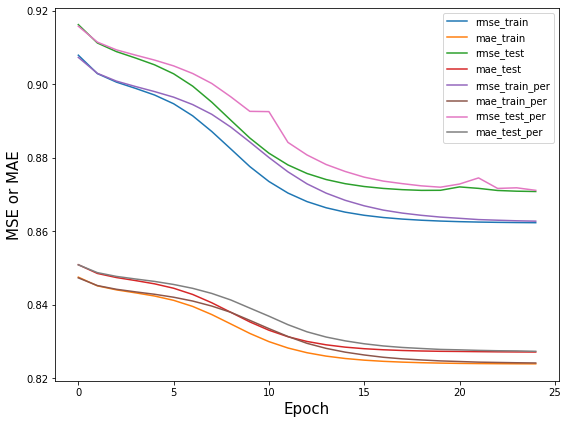

In [14]:
epochs = np.arange(0,25,1)
fig = plt.figure(figsize=(8,6))
plt.plot(epochs,rmse_train,label='rmse_train')
plt.plot(epochs,mae_train,label='mae_train')
plt.plot(epochs,rmse_test,label='rmse_test')
plt.plot(epochs,mae_test,label='mae_test')

plt.plot(epochs,rmse_train_per,label='rmse_train_per')
plt.plot(epochs,mae_train_per,label='mae_train_per')
plt.plot(epochs,rmse_test_per,label='rmse_test_per')
plt.plot(epochs,mae_test_per,label='mae_test_per')

plt.xlabel('Epoch',fontsize=15)
plt.ylabel('MSE or MAE',fontsize=15)

plt.legend()
plt.tight_layout()
fig.savefig('uvdecom.pdf')

In [ ]:
## New figure

epochs = np.arange(0,25,1)
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(epochs,rmse_train,label='rmse_train')
ax[1].plot(epochs,mae_train,label='mae_train')
ax[0].plot(epochs,rmse_test,label='rmse_test')
ax[1].plot(epochs,mae_test,label='mae_test')


ax[0].plot(epochs,rmse_train_per,label='rmse_train_per')
ax[1].plot(epochs,mae_train_per,label='mae_train_per')
ax[0].plot(epochs,rmse_test_per,label='rmse_test_per')
ax[1].plot(epochs,mae_test_per,label='mae_test_per')

plt.xlabel('Epoch',fontsize=15)

ax[0].set_ylabel("RMSE",fontsize=15)
ax[0].legend(prop={'size': 15})
ax[1].set_ylabel("MAE",fontsize=15)
ax[1].legend(prop={'size': 15})

plt.tight_layout()
fig.savefig('uvdecom.pdf')


# Matrix factorization

## Functions

In [15]:
def mf_fold_error(ratings, train_indices, test_indices, users, movies, factors, n_training_steps, lr, lam):
    """
    For a given fold, train the UM matrix and keep track of the rating errors on the train and test set.
    
    ratings: Dataframe, dataframe containing the ratings
    train_indices: array, indices of the training set
    test_indices array, indices of the test set
    users: Dataframe, dataframe containing the users
    movies: Dataframe, dataframe containing the movies
    factors: int, the number of factors to use for the U and M matrix
    n_training_steps: int, the number of steps for training
    lr: float, learning rate 
    lam: float, lambda (used for regularization)
    """
    n_users = len(users)
    n_movies = len(movies)
    
    U = np.random.normal(0.0, 1.0, ((n_users, factors)))
    M = np.random.normal(0.0, 1.0, ((factors, n_movies)))
    
    train_set = ratings.iloc[train_indices]
    test_set = ratings.iloc[test_indices]
    
    # Define an index for every user ID
    train_user_indices = train_set['UserID'].values - 1
    test_user_indices = test_set['UserID'].values - 1
    
    # Define an index for every movie ID
    movie_ids = movies['MovieID'].values
    train_movie_indices = make_movie_indices(train_set, movie_ids)
    test_movie_indices = make_movie_indices(test_set, movie_ids)
    
    # Create a matrix for looking up train set ratings
    train_set_rating_matrix = np.zeros((n_users, n_movies))
    for u, m, rating in zip(train_user_indices, train_movie_indices, train_set['Rating']):
        train_set_rating_matrix[u, m] = rating
    
    errors = np.empty((0, 4))

    for step in range(n_training_steps):
        # Calculate the errors of the ratings predicted by the dot product of U and M
        predicted_ratings = np.dot(U, M)

        train_set_predicted_ratings = predicted_ratings[train_user_indices, train_movie_indices]
        test_set_predicted_ratings = predicted_ratings[test_user_indices, test_movie_indices]

        train_errors = train_set['Rating'] - crop_ratings(train_set_predicted_ratings)
        test_errors = test_set['Rating'] - crop_ratings(test_set_predicted_ratings)
        
        train_rmse, test_rmse = rmse(train_errors), rmse(test_errors)
        
        errors = np.append(errors, np.array([[train_rmse, 
                                              test_rmse, 
                                              mae(train_errors), 
                                              mae(test_errors)]]), axis=0)

        mp_lock.acquire()
        print('step ', step, ' rmse train ', train_rmse, ' rmse test ', test_rmse)
        mp_lock.release()
        
        # Update the U and M matrix
        for u, m in zip(train_user_indices, train_movie_indices):
            u_vec, m_vec = U[u, :], M[:, m]
            error = train_set_rating_matrix[u, m] - np.dot(u_vec, m_vec)
            U[u, :] += lr * (2 * error * m_vec - lam * u_vec)
            M[:, m] += lr * (2 * error * U[u, :] - lam * m_vec)
    
    # errors has shape [n_training_steps, n_error_types]
    return errors


def matrix_factorization(data, factors, n_training_steps, lr, lam, n_folds):
    """
    Calculates the error for the matrix factorization model. Bias in training and test set 
    selection is reduced by using cross-validation. To speed up the process, we use multiprocessing 
    to divide the folds over different cores.
    
    data: tuple, contains the user, movie and rating dataframe
    factors: int, the number of factors to use for the U and M matrix
    n_training_steps: int, the number of steps for training
    lr: float, learning rate 
    lam: float, lambda (used for regularization)
    n_folds: int, the number of folds to use for cross-validation
    """
    users, movies, ratings = data

    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)

    print('Testing matrix factorization model...')
    
    # Simulatneously calculate the errors for each fold
    params = [(ratings,
               train_indices, 
               test_indices, 
               users, 
               movies, 
               factors, 
               n_training_steps, 
               lr, 
               lam) for train_indices, test_indices in cv.split(ratings)]
    pool = Pool(n_folds)
    fold_errors = pool.starmap(mf_fold_error, params)
    pool.close()
    pool.join()
    
    # fold_errors has dimensions [n_folds, n_training_steps, n_error_types]
    return np.transpose(np.array(fold_errors), (0, 2, 1))

## Testing matrix factorization

In [16]:
# Use a lock to prevent print statements from being scrambled
mp_lock = Lock()

number_of_folds = 5
number_of_training_steps = 75
number_of_factors = 10
learning_rate = 0.005
regularization = 0.05

np.random.seed(42)

t0 = time.time()

errors = matrix_factorization(data,
                              factors=number_of_factors,
                              n_training_steps=number_of_training_steps,
                              lr=learning_rate,
                              lam=regularization,
                              n_folds=number_of_folds)

mean_train_rmses = np.mean(errors, axis=0)[0]
mean_test_rmses = np.mean(errors, axis=0)[1]
mean_train_maes = np.mean(errors, axis=0)[2]
mean_test_maes = np.mean(errors, axis=0)[3]

print('\nResults:')
print('Final train rmse:', np.min(mean_train_rmses))
print('Final test rmse:', np.min(mean_test_rmses))
print('Final train mae:', np.min(mean_train_maes))
print('Final test mae:', np.min(mean_test_maes))

run_time = time.time() - t0

print('Run time:', run_time, 'sec')

Testing matrix factorization model...
step  0  rmse train  2.5019508435204645  rmse test  2.505985745810919
step  0  rmse train  2.502395730645005  rmse test  2.504208276463159
step  0  rmse train  2.5036820837908937  rmse test  2.499059980936231
step  0  rmse train  2.50312504692612  rmse test  2.5012910024548005
step  0  rmse train  2.502637664414911  rmse test  2.50324101250093
step  1  rmse train  1.374578568091938  rmse test  1.4082948269287678
step  1  rmse train  1.3855486453868322  rmse test  1.4206325506612607
step  1  rmse train  1.37838342989016  rmse test  1.406812417182056
step  1  rmse train  1.3837881339852656  rmse test  1.4131832873445507
step  1  rmse train  1.3784721322705848  rmse test  1.4177585161228956
step  2  rmse train  0.9809674959677085  rmse test  1.0385716351252674
step  2  rmse train  0.9847830519497771  rmse test  1.0361493841791471
step  2  rmse train  0.9858098279682455  rmse test  1.0369542545872932
step  2  rmse train  0.9839282514083296  rmse test  

step  45  rmse train  0.7968045595934697  rmse test  0.8927830431284217
step  45  rmse train  0.7972037585181024  rmse test  0.8922197913902212
step  46  rmse train  0.7955227293599264 0.8907121649091126  rmse test 
step  46  rmse train  0.7954744008397058  rmse test  0.8893388743630711
step  46  rmse train  0.7969198297799978  rmse test  0.8960216582005549
step  46  rmse train  0.795847388077164  rmse test  0.8923309821280001
step  46  rmse train  0.7962908379331431  rmse test  0.891776226613867
step  47  rmse train  0.7946058392971822  rmse test  0.8902331425742291
step  47  rmse train  0.7945555066743207  rmse test  0.8888973430361786
step  47  rmse train  0.7960080918676763  rmse test  0.8955339235359496
step  47  rmse train  0.7949277444230625  rmse test  0.8918974075045495
step  47  rmse train  0.7954142298384029  rmse test  0.8913517067960152
step  48  rmse train  0.7937237756939209  rmse test  0.8897723033920493
step  48  rmse train  0.7936715600002023  rmse test  0.88847509713

## Plots

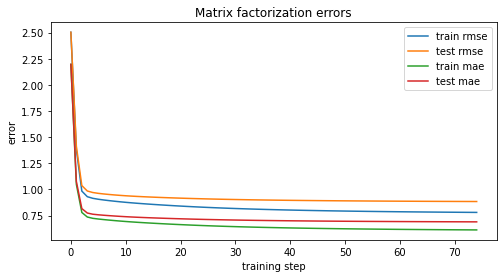

In [17]:
training_steps = np.arange(number_of_training_steps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(training_steps, mean_train_rmses, label='train rmse', rasterized=True)
ax.plot(training_steps, mean_test_rmses, label='test rmse', rasterized=True)
ax.plot(training_steps, mean_train_maes, label='train mae', rasterized=True)
ax.plot(training_steps, mean_test_maes, label='test mae', rasterized=True)
ax.set_title('Matrix factorization errors')
ax.set_xlabel('training step')
ax.set_ylabel('error')
ax.legend()
plt.savefig('mf_errors.pdf')
plt.show()